<a href="https://colab.research.google.com/github/aydawudu/GCP/blob/main/Keras_DNN_Taxi_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, json, math
import numpy as np
import shutil
import tensorflow as tf
print("TensorFlow version:", tf.version.VERSION)

os.environ['TF_CPP_MIN_LOG_LEVEL']='3' #set TF Error log verbosity

TensorFlow version: 2.8.2


In [2]:
#Use tf.data to read in CSV files
#define CSV_Column
CSV_COLUMNS  = ['fare_amount',  'pickup_datetime',
                'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 
                'passenger_count', 'key']
LABEL_COLUMN='fare_amount'
DEFAULTS=[[0.0], ['na'], [0.0], [0.0], [0.0], [0.0], [0.0], ['na']]


In [3]:
#Defining the features we are interested in and the label and load in the dataset for training
def features_and_labels(row_data):
  for unwanted_col in ['pickup_datetime', 'key']:
    row_data.pop(unwanted_col)
  label=row_data.pop(LABEL_COLUMN)
  return row_data, label # features and label

#load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
           .map(features_and_labels)
           )
  if mode == tf.estimator.ModeKeys.TRAIN:
    dataset=dataset.shuffle(1000).repeat()
  dataset=dataset.prefetch(1)
  return dataset

## Building DNN keras

In [4]:
from tensorflow.python.feature_column import feature_column
#Using functional API
def rmse(y_true, y_pred):
  return tf.sqrt(tf.reduce_mean(tf.square(y_pred-y_true)))

def build_dnn_models():
    INPUT_COLS = ['pickup_longitude', 'pickup_latitude', 
                  'dropoff_longitude', 'dropoff_latitude', 
                  'passenger_count']
    #input layer
    inputs={
        colname:tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
        for colname in INPUT_COLS
    }

    #tf.feature_column.numeric_column() represents real valued or numerical feature
    feature_columns ={
        colname: tf.feature_column.numeric_column(colname)
        for colname in INPUT_COLS
    }


    #the constructor for DenseFeatures takes a list of numeric columns
    # Using the functional API in keras
    dnn_inputs=tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)

    #two hidden layers of [32, 9]
    h1=tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2=tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)

    #final output is a linear activation 
    output=tf.keras.layers.Dense(1, activation='linear', name='fare')(h2)
    model=tf.keras.models.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

print("Here is the DNN architecture so far: \n")
model=build_dnn_models()
print(model.summary())


Here is the DNN architecture so far: 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dropoff_latitude (InputLayer)  [(None,)]            0           []                               
                                                                                                  
 dropoff_longitude (InputLayer)  [(None,)]           0           []                               
                                                                                                  
 passenger_count (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 pickup_latitude (InputLayer)   [(None,)]            0           []                               
                                                       

##Visualize the DNN using plot_model utility

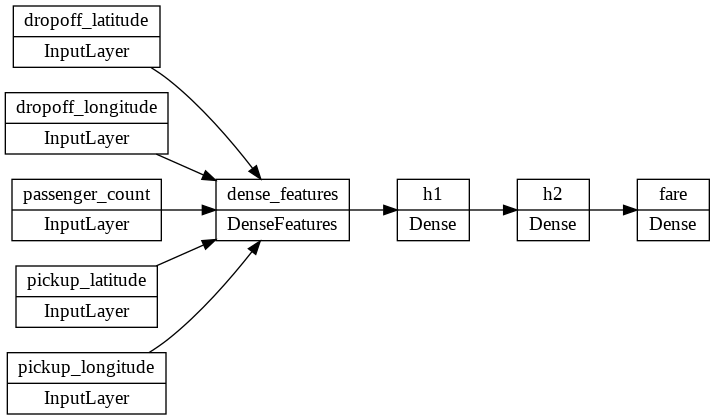

In [5]:
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

## Train the model

In [7]:
TRAIN_BATCH_SIZE=32
NUM_TRAIN_EXAMPLES=10000 * 5 #training dataset repeats, so it will wrap around
NUM_EVALS=32 #How many times to evaluate
NUM_EVAL_EXAMPLES=10000 #enough to get a reasonalbe sample and not too much so that it slows down

#load ds
trainds=load_dataset('/content/taxi-train.csv', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds=load_dataset('/content/taxi-valid.csv', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES)

steps_per_epoch=NUM_EVAL_EXAMPLES//(TRAIN_BATCH_SIZE * NUM_EVALS)

#Model Fit
history=model.fit(trainds,
                  validation_data=evalds, 
                  epochs=NUM_EVALS, 
                  steps_per_epoch=steps_per_epoch)

Epoch 1/32
9/9 [==============================] - 134s 16s/step - loss: 104.2387 - rmse: 10.0452 - mse: 104.2387 - val_loss: 104.3536 - val_rmse: 10.2098 - val_mse: 104.3536
Epoch 2/32
9/9 [==============================] - 129s 16s/step - loss: 74.3279 - rmse: 8.4097 - mse: 74.3279 - val_loss: 99.4972 - val_rmse: 9.9702 - val_mse: 99.4972
Epoch 3/32
9/9 [==============================] - 132s 17s/step - loss: 103.5505 - rmse: 9.6041 - mse: 103.5505 - val_loss: 101.8122 - val_rmse: 10.0847 - val_mse: 101.8122
Epoch 4/32
9/9 [==============================] - 128s 16s/step - loss: 128.2519 - rmse: 10.5892 - mse: 128.2519 - val_loss: 99.3692 - val_rmse: 9.9635 - val_mse: 99.3692
Epoch 5/32
9/9 [==============================] - 128s 16s/step - loss: 62.8724 - rmse: 7.7170 - mse: 62.8724 - val_loss: 100.1580 - val_rmse: 10.0026 - val_mse: 100.1580
Epoch 6/32
9/9 [==============================] - 133s 17s/step - loss: 64.3951 - rmse: 7.7536 - mse: 64.3951 - val_loss: 104.7879 - val_rmse: 

## Visualize the model loss curve

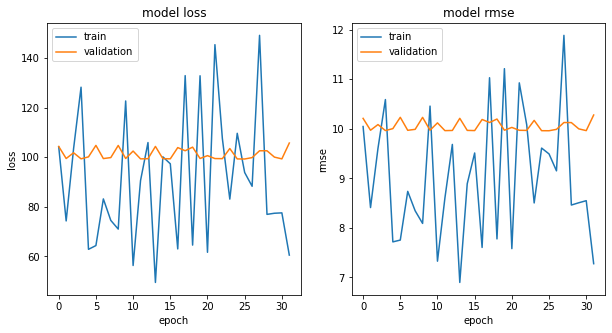

In [8]:
import matplotlib.pyplot as plt
nrows=1
ncols= 2

#the figure method will activate an exsiting figure or createa new figure.
fig=plt.figure(figsize=(10,5))

for idx, key in enumerate(['loss', 'rmse']):
  ax=fig.add_subplot(nrows, ncols, idx+1)

  plt.plot(history.history[key])
  plt.plot(history.history['val_{}'.format(key)])
  plt.title(f"model {key}")
  plt.ylabel(key)
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left');

## Predict locally

In [9]:
model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),    
}, steps=1)

array([[8.963201]], dtype=float32)